Let us get our hands dirty and have a look at our hypothetical web startup, MLAAS, which sells the service of providing machine learning algorithms via HTTP. With the increasing success of our company, the demand for better infrastructure also increases to serve all incoming web requests successfully. We don't want to allocate too many resources as that would be too costly. On the other hand, we will lose money if we have not reserved enough resources for serving all incoming requests.

The question now is, when will we hit the limit of our current infrastructure, which we estimated being 100,000 requests per hour. We would like to know in advance when we have to request additional servers in the cloud to serve all the incoming requests successfully without paying for unused ones.

# Reading in the data

We have collected the web stats for the last month and aggregated them in `web_traffic.tsv` (`tsv` because it contains tab separated values). They are stored as the number of hits per hour. Each line contains consecutive hours and the number of web hits in that hour.

Using SciPy's `genfromtxt()`, we can easily read in the data.
We have to specify tab as the delimiter so that the columns are correctly determined.

In [1]:
import scipy as sp

In [2]:
data = sp.genfromtxt("web_traffic.tsv", delimiter="\t")

A quick check shows that we have correctly read in the data.

In [3]:
print(data[:10])
print(data.shape)

[[1.000e+00 2.272e+03]
 [2.000e+00       nan]
 [3.000e+00 1.386e+03]
 [4.000e+00 1.365e+03]
 [5.000e+00 1.488e+03]
 [6.000e+00 1.337e+03]
 [7.000e+00 1.883e+03]
 [8.000e+00 2.283e+03]
 [9.000e+00 1.335e+03]
 [1.000e+01 1.025e+03]]
(743, 2)


We have 743 data points with two dimensions.

# Preprocessing and cleaning the data

It is more convenient for SciPy to separate the dimensions into two vectors, each of size 743. The first vector, `x`, will contain the hours and the other, `y`, will contain the web hits in that particular hour.

This splitting is done using the special index notation of SciPy, using which we can choose the columns individually.

In [4]:
x = data[:,0]
y = data[:,1]

One caveat is that we still have some values in `y` that contain invalid values, `nan`.

The question is, what can we do with them? Let us check how many hours contain invalid data.

In [5]:
sp.sum(sp.isnan(y))

8

We are missing only 8 out of 743 entries, so we can afford to remove them. Remember that we can index a SciPy array with another array.

`sp.isnan(y)` returns an array of Booleans indicating whether an entry is not a number. Using `~`, we logically negate that array so that we choose only those elements from `x` and `y` where `y` does contain valid numbers.

In [6]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

To get a first impression of our data, let us plot the data in a scatter plot using Matplotlib. Matplotlib contains the `pyplot` package, which tries to mimic Matlab's interface—a very convenient and easy-to-use one (you will find more tutorials on plotting at http://matplotlib.org/users/pyplot_tutorial.html).

In [7]:
import matplotlib.pyplot as plt

In [8]:
colors = ['g', 'k', 'b', 'm', 'r']
linestyles = ['-', '-.', '--', ':', '-']

def plot_models(x, y, models, fname, mx=None, ymax=None, xmin=None):
    plt.clf()
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks(
        [w * 7 * 24 for w in range(10)], ['week %i' % w for w in range(10)])

    if models:
        if mx is None:
            mx = sp.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            # print "Model:",model
            # print "Coeffs:",model.coeffs
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0)
    if ymax:
        plt.ylim(ymax=ymax)
    if xmin:
        plt.xlim(xmin=xmin)
    plt.grid(True, linestyle='-', color='0.75')
    plt.savefig(fname)

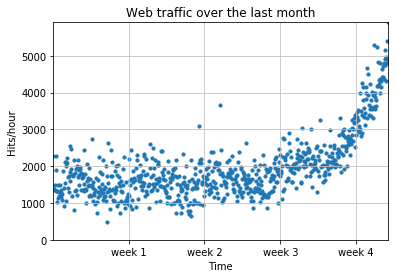

In [9]:
plot_models(x, y, None, "web_traffic.png")

In the resulting chart, we can see that while in the first weeks the traffic stayed more or less the same, the last week shows a steep increase.

# Choosing the right model and learning algorithm

Now that we have a first impression of the data, we return to the initial question: how long will our server handle the incoming web traffic? To answer this we have to:

- Find the real model behind the noisy data points
- Use the model to extrapolate into the future to find the point in time where our infrastructure has to be extended

## Before building our first model

When we talk about models, you can think of them as **simplified theoretical approximations of the complex reality**. As such there is always some inferiority involved, also called the approximation error. This error will guide us in choosing the right model among the myriad of choices we have. This error will be calculated as the squared distance of the model's prediction to the real data. That is, for a learned model function, `f`, the error is calculated as follows:

In [10]:
def error(f, x, y):
    return sp.sum((f(x)-y)**2)

The vectors `x` and `y` contain the web stats data that we have extracted before. It is the beauty of SciPy's vectorized functions that we exploit here with `f(x)`. The trained model is assumed to take a vector and return the results again as a vector of the same size so that we can use it to calculate the difference to `y`.

## Starting with a simple straight line

Let us assume for a second that the underlying model is a straight line. The challenge then is how to best put that line into the chart so that it results in the smallest approximation error. SciPy's `polyfit()` function does exactly that. Given data `x` and `y` and the desired order of the polynomial (straight line has order `1`), it finds the model function that minimizes the error function defined earlier.

In [11]:
fp1, residuals, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)

The `polyfit()` function returns the parameters of the fitted model function, `fp1`; and by setting `full` to `True`, we also get additional background information on the fitting process. Of it, only residuals are of interest, which is exactly the error of the approximation.

In [12]:
print("Model parameters: %s" % fp1)
print(residuals)

Model parameters: [  2.59619213 989.02487106]
[3.17389767e+08]


This means that the best straight line fit is the following function:

```
f(x) = 2.59619213 * x + 989.02487106.
```

We then use `poly1d()` to create a model function from the model parameters.

In [13]:
f1 = sp.poly1d(fp1)
print(error(f1, x, y))

317389767.339778


We have used `full=True` to retrieve more details on the fitting process. Normally, we would not need it, in which case only the model parameters would be returned.

> In fact, what we do here is **simple curve fitting**. You can find out more about it on Wikipedia by going to http://en.wikipedia.org/wiki/Curve_fitting.

We can now use `f1()` to plot our first trained model. In addition to the earlier plotting instructions, we simply add the following:

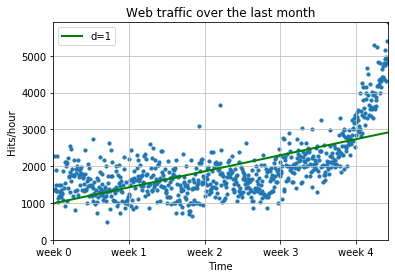

In [14]:
plot_models(x, y, [f1], "polynomial-1.png")

It seems like the first four weeks are not that far off, although we clearly see that there is something wrong with our initial assumption that the underlying model is a straight line. Plus, how good or bad actually is the error of 317,389,767.34?

The absolute value of the error is seldom of use in isolation. However, when comparing two competing models, we can use their errors to judge which one of them is better. Although our first model clearly is not the one we would use, it serves a very important purpose in the workflow: we will use it as our baseline until we find a better one. Whatever model we will come up with in the future, we will compare it against the current baseline.

## Towards some advanced stuff

Let us now fit a more complex model, a polynomial of degree 2, to see whether it better "understands" our data:

In [15]:
f2p = sp.polyfit(x, y, 2)
print(f2p)

f2 = sp.poly1d(f2p)
print(error(f2, x, y))

[ 1.05322215e-02 -5.26545650e+00  1.97476082e+03]
179983507.8781792


The following chart shows the model we trained before (straight line of one degree) with our newly trained, more complex model with two degrees (dashed):

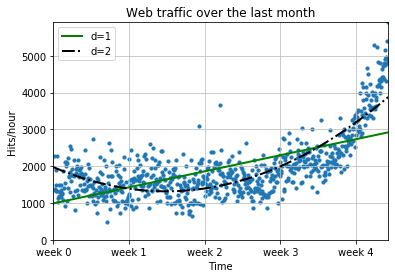

In [16]:
plot_models(x, y, [f1, f2], "polynomial-1-2.png")

The error is 179,983,507.878, which is almost half the error of the straight-line model. This is good; however, it comes with a price. We now have a more complex function, meaning that we have one more parameter to tune inside `polyfit()`. The fitted polynomial is as follows:

```
f(x) = 0.0105322215 * x**2  - 5.26545650 * x + 1974.76082
```

So, if more complexity gives better results, why not increase the complexity even more? Let's try it for degree 3, 10, and 100.

/usr/local/lib/python3.7/site-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


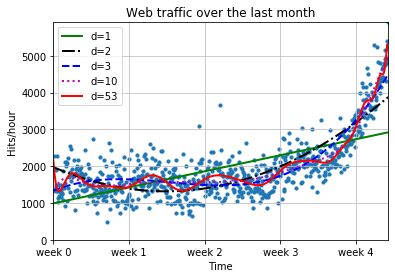

In [17]:
f3 = sp.poly1d(sp.polyfit(x, y, 3))
f10 = sp.poly1d(sp.polyfit(x, y, 10))
f100 = sp.poly1d(sp.polyfit(x, y, 100))

plot_models(x, y, [f1, f2, f3, f10, f100], "polynomial-1-2-3-10-100.png")

The more complex the data gets, the curves capture it and make it fit better. The errors seem to tell the same story.

In [18]:
print("Error d=1:", error(f1, x, y))
print("Error d=2:", error(f2, x, y))
print("Error d=3:", error(f3, x, y))
print("Error d=10:", error(f10, x, y))
print("Error d=100:", error(f100, x, y))

Error d=1: 317389767.339778
Error d=2: 179983507.8781792
Error d=3: 139350144.03172523
Error d=10: 121942326.36358732
Error d=100: 109452409.43398768


However, taking a closer look at the fitted curves, we start to wonder whether they also capture the true process that generated this data. Framed differently, do our models correctly represent the underlying mass behavior of customers visiting our website? Looking at the polynomial of degree 10 and 100, we see wildly oscillating behavior. It seems that the models are fitted too much to the data. So much that it is now capturing not only the underlying process but also the noise. This is called **overfitting**.

At this point, we have the following choices:

- Selecting one of the fitted polynomial models.
- Switching to another more complex model class; splines?
- Thinking differently about the data and starting again.

Of the five fitted models, the first-order model clearly is too simple, and the models of order 10 and 100 are clearly overfitting. Only the second- and third-order models seem to somehow match the data. However, if we extrapolate them at both borders, we see them going berserk.

Switching to a more complex class also seems to be the wrong way to go about it. What arguments would back which class? At this point, we realize that we probably have not completely understood our data.

## Stepping back to go forward – another look at our data

So, we step back and take another look at the data. It seems that there is an **inflection point** between weeks 3 and 4. So let us separate the data and train two lines using week 3.5 as a separation point. We train the first line with the data up to week 3, and the second line with the remaining data.

In [19]:
# fit and plot a model using the knowledge about inflection point
inflection = int(3.5 * 7 * 24)

xa = x[:inflection]
ya = y[:inflection]
xb = x[inflection:]
yb = y[inflection:]

fa = sp.poly1d(sp.polyfit(xa, ya, 1))
fb = sp.poly1d(sp.polyfit(xb, yb, 1))

Plotting the two models for the two data ranges gives the following chart:

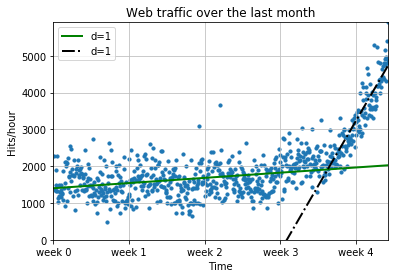

In [20]:
plot_models(x, y, [fa, fb], "inflection-point.png")

Clearly, the combination of these two lines seems to be a much better fit to the data than anything we have modeled before. But still, the combined error is higher than the higher-order polynomials. Can we trust the error at the end?

In [21]:
print("Errors for the complete data set:")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, x, y)))
print()

print("Errors for only the time after inflection point")
for f in [f1, f2, f3, f10, f100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))
print()

print("Error inflection=%f" % (error(fa, xa, ya) + error(fb, xb, yb)))

Errors for the complete data set:
Error d=1: 317389767.339778
Error d=2: 179983507.878179
Error d=3: 139350144.031725
Error d=10: 121942326.363587
Error d=53: 109452409.433988

Errors for only the time after inflection point
Error d=1: 145045835.134473
Error d=2: 61116348.809620
Error d=3: 33214248.905597
Error d=10: 21611594.263692
Error d=53: 18656105.795149

Error inflection=132950348.197616


Asked differently, why do we trust the straight line fitted only at the last week of our data more than any of the more complex models? It is because we assume that it will capture future data better. If we plot the models into the future, we see how right we are (**d=1** is again our initially straight line).

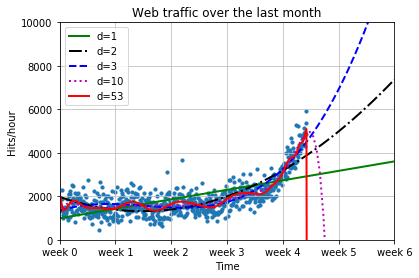

In [22]:
plot_models(
    x, y, [f1, f2, f3, f10, f100], "extrapolating-into-the-future-0.png",
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

The models of degree 10 and 100 don't seem to expect a bright future for our startup. They tried so hard to model the given data correctly that they are clearly useless to extrapolate further. This is called overfitting. On the other hand, the lower-degree models do not seem to be capable of capturing the data properly. This is called **underfitting**.

So let us play fair to the models of degree 2 and above and try out how they behave if we fit them only to the data of the last week. After all, we believe that the last week says more about the future than the data before. The result can be seen in the following psychedelic chart, which shows even more clearly how bad the problem of overfitting is:

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


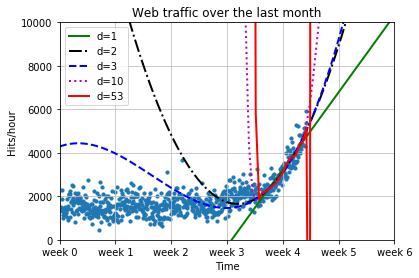

In [23]:
fb1 = fb
fb2 = sp.poly1d(sp.polyfit(xb, yb, 2))
fb3 = sp.poly1d(sp.polyfit(xb, yb, 3))
fb10 = sp.poly1d(sp.polyfit(xb, yb, 10))
fb100 = sp.poly1d(sp.polyfit(xb, yb, 100))
    
plot_models(
    x, y, [fb1, fb2, fb3, fb10, fb100], "extrapolate-after-inflection.png",
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

Still, judging from the errors of the models when trained only on the data from week 3.5 and after, we should still choose the most complex one.

In [24]:
for f in [fb1, fb2, fb3, fb10, fb100]:
    print("Error d=%i: %f" % (f.order, error(f, xb, yb)))

Error d=1: 22143941.107618
Error d=2: 19768846.989176
Error d=3: 19766452.361027
Error d=10: 18949296.721348
Error d=53: 18300750.006311


## Training and testing

If only we had some data from the future that we could use to measure our models against, we should be able to judge our model choice only on the resulting approximation error.

Although we cannot look into the future, we can and should simulate a similar effect by holding out a part of our data. Let us remove, for instance, a certain percentage of the data and train on the remaining one. Then we use the hold-out data to calculate the error. As the model has been trained not knowing the hold-out data, we should get a more realistic picture of how the model will behave in the future.

In [25]:
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = sp.random.permutation(list(range(len(xb))))

test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])

fbt1 = sp.poly1d(sp.polyfit(xb[train], yb[train], 1))
fbt2 = sp.poly1d(sp.polyfit(xb[train], yb[train], 2))
fbt3 = sp.poly1d(sp.polyfit(xb[train], yb[train], 3))
fbt10 = sp.poly1d(sp.polyfit(xb[train], yb[train], 10))
fbt100 = sp.poly1d(sp.polyfit(xb[train], yb[train], 100))

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


The test errors for the models trained only on the time after the inflection point now show a completely different picture.

In [26]:
for f in [fbt1, fbt2, fbt3, fbt10, fbt100]:
    print("Error d=%i: %f" % (f.order, error(f, xb[test], yb[test])))

Error d=1: 7395005.492214
Error d=2: 6320819.003802
Error d=3: 6658162.445730
Error d=10: 6776429.317802
Error d=53: 9018385.121948


The result can be seen in the following chart:

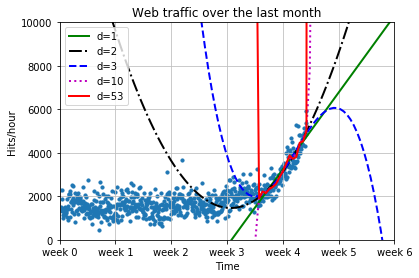

In [27]:
plot_models(
    x, y, [fbt1, fbt2, fbt3, fbt10, fbt100], "train_result.png",
    mx=sp.linspace(0 * 7 * 24, 6 * 7 * 24, 100),
    ymax=10000, xmin=0 * 7 * 24)

It seems we finally have a clear winner. The model with degree 2 has the lowest test error, which is the error when measured using data that the model did not see during training. And this is what lets us trust that we won't get bad surprises when future data arrives.

## Answering our initial question

Finally, we have arrived at a model that we think represents the underlying process best; it is now a simple task of finding out when our infrastructure will reach 100,000 requests per hour. We have to calculate when our model function reaches the value 100,000.

Having a polynomial of degree 2, we could simply compute the inverse of the function and calculate its value at 100,000. Of course, we would like to have an approach that is applicable to any model function easily.

This can be done by subtracting 100,000 from the polynomial, which results in another polynomial, and finding the root of it. SciPy's optimize module has the fsolve function to achieve this when providing an initial starting position. Let fbt2 be the winning polynomial of degree 2:

In [28]:
print(fbt2)
print(fbt2 - 100000)

from scipy.optimize import fsolve
reached_max = fsolve(fbt2 - 100000, 800) / (7 * 24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

         2
0.06763 x - 69.71 x + 1.942e+04
         2
0.06763 x - 69.71 x - 8.058e+04
100,000 hits/hour expected at week 10.252376


Our model tells us that given the current user behavior and traction of our startup, it will take another month until we have reached our threshold capacity.

Of course, there is a certain uncertainty involved with our prediction. To get the real picture, you can draw in more sophisticated statistics to find out about the variance that we have to expect when looking farther and further into the future.

And then there are the user and underlying user behavior dynamics that we cannot model accurately. However, at this point we are fine with the current predictions. After all, we can prepare all the time-consuming actions now. If we then monitor our web traffic closely, we will see in time when we have to allocate new resources.

# Summary

Congratulations! You just learned two important things. Of these, the most important one is that as a typical machine learning operator, you will spend most
of your time understanding and refining the data—exactly what we just did in our first tiny machine learning example. And we hope that the example helped you to start switching your mental focus from algorithms to data. Later, you learned how important it is to have the correct experiment setup, and that it is vital to not mix up training and testing.

Admittedly, the use of polynomial fitting is not the coolest thing in the machine learning world. We have chosen it so as not to distract you with the coolness of some shiny algorithm, which encompasses the two most important points we just summarized above.